Let's start by downloading a small portion of data. NASA's PDS-PPI node for MESSENGER stores full cadence data in daily files, so we will just download one of these.

In [1]:
import datetime as dt
import os
import pathlib
import requests
import sys

import hermpy.utils
import hermpy.mag
import hermpy.plotting
import matplotlib.dates
import matplotlib.pyplot as plt

In [2]:
# 1st September 2011
url = "https://pds-ppi.igpp.ucla.edu/data/mess-mag-calibrated/data/mso/2011/244_273_SEP/MAGMSOSCI11244_V08.TAB"

save_dir = "../data/tmp/"
filename = os.path.basename(url)
save_path = os.path.join(save_dir, filename)
os.makedirs(save_dir, exist_ok=True)

# Check if we've downloaded the file already:
if not os.path.exists(save_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(save_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

print(f"Data saved to: {save_path}")

Data saved to: ../data/tmp/MAGMSOSCI11244_V08.TAB


We require a SPICE metakernel for MESSENGER. This can be created automatically with the below code. This only needs to be run once.

In [3]:
if not os.path.isdir("../data/autometa/"):
    os.system("git clone 'https://github.com/mjrutala/AutoMeta.git' ../data/autometa")

if not os.path.isdir("./SPICE/"):
    sys.path.insert(
        1, str("../data/autometa")
    )
    from autometa import make_Metakernel
    
    make_Metakernel.make_Metakernel("MESSENGER", ".")

Lastly, we can download a prebuilt model to run on the data. For more information on how this model was create, see [here](../docs/REPRODUCE.md)

In [4]:
url = "https://github.com/daraghhollman/messenger_region_classifier/releases/download/quicklook_model_v0.1.0/messenger_region_classifier.pkl"

save_dir = "../data/model/"
filename = os.path.basename(url)
save_path = os.path.join(save_dir, filename)
os.makedirs(save_dir, exist_ok=True)

# Check if we've downloaded the file already:
if not os.path.exists(save_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(save_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

print(f"Model saved to: {save_path}")

Model saved to: ../data/model/messenger_region_classifier.pkl


We need to tell the hermpy package where to expect our data files:

In [5]:
hermpy.utils.User.DATA_DIRECTORIES["MAG_FULL"] = "../data/tmp/"
hermpy.utils.User.METAKERNEL = "./SPICE/messenger/metakernel_messenger.txt"

That's all of the set up out of the way, we can now load our data and run our model on it!

Let's first take a look at the data itself:

In [6]:
# Define a time range to look at
start_time = dt.datetime(2011, 9, 1, 9)
end_time = dt.datetime(2011, 9, 1, 11)

# Load the data into memory
data = hermpy.mag.Load_Between_Dates(
    hermpy.utils.User.DATA_DIRECTORIES["MAG_FULL"],
    start_time,
    end_time,
    average=None, # Here we tell hermpy to expect full cadence data, rather than an averaged product.
    no_dirs=True # Here we tell hermpy to expect data files in one directory, rather than the directory structure they exist in on the pds
)

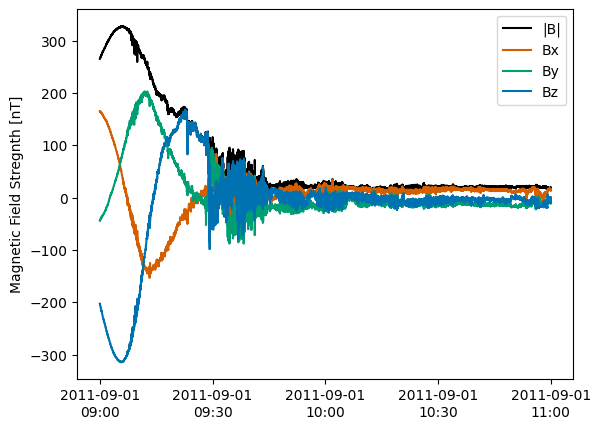

In [7]:
# Lets visualise this time range
fig, ax = plt.subplots()

to_plot = ["|B|", "Bx", "By", "Bz"]
colours = [hermpy.plotting.wong_colours[c] for c in ["black", "red", "green", "blue"]]

for var, colour in zip(to_plot, colours):
    ax.plot(data["date"], data[var], color=colour, label=var)

ax.legend()
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator([0, 30]))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.set_ylabel("Magnetic Field Stregnth [nT]");

Now we can pass this data to our model and look at the predictions

In [8]:
sys.path.insert(
    1, str("../src/")
)
from apply_model import get_magnetospheric_region

region_probabilities = get_magnetospheric_region(
    start_time,
    end_time,
    model_path="../data/model/messenger_region_classifier.pkl"
)

Calculating features: 100%|██████████| 7191/7191 [00:23<00:00, 309.74it/s]


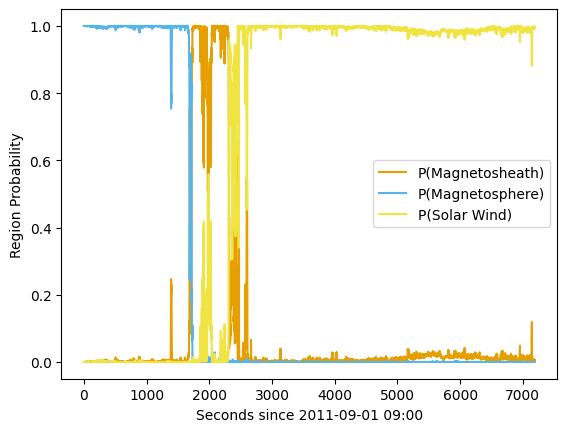

In [9]:
# Now lets look at these probabilities in time

fig, ax = plt.subplots()

labels = ["P(Magnetosheath)", "P(Magnetosphere)", "P(Solar Wind)"]
colours = [hermpy.plotting.wong_colours[c] for c in ["orange", "light blue", "yellow"]]

for i, (colour, label) in enumerate(zip(colours, labels)):
    ax.plot(range(len(region_probabilities)), region_probabilities[:, i], color=colour, label=label)

ax.legend()
ax.set_xlabel("Seconds since 2011-09-01 09:00")
ax.set_ylabel("Region Probability");

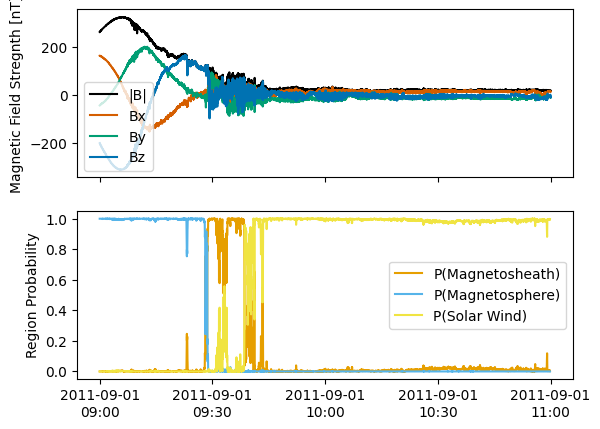

In [10]:
# Or better yet, we can stack these two plots together
fig, axes = plt.subplots(2, 1, sharex=True)
mag_ax, proba_ax = axes

to_plot = ["|B|", "Bx", "By", "Bz"]
mag_colours = [hermpy.plotting.wong_colours[c] for c in ["black", "red", "green", "blue"]]

for var, colour in zip(to_plot, mag_colours):
    mag_ax.plot(data["date"], data[var], color=colour, label=var)

mag_ax.legend()
mag_ax.set_ylabel("Magnetic Field Stregnth [nT]")

labels = ["P(Magnetosheath)", "P(Magnetosphere)", "P(Solar Wind)"]
region_colours = [hermpy.plotting.wong_colours[c] for c in ["orange", "light blue", "yellow"]]

probability_times = [start_time + dt.timedelta(seconds=t) for t in range(len(region_probabilities))]

for i, (colour, label) in enumerate(zip(region_colours, labels)):
    proba_ax.plot(probability_times, region_probabilities[:, i], color=colour, label=label)

proba_ax.legend()
proba_ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator([0, 30]))
proba_ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m-%d\n%H:%M"))
proba_ax.set_ylabel("Region Probability");